<a href="https://colab.research.google.com/github/priyaadepu/project-8-Recommender/blob/main/recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
!pip install scikit-surprise

In [ ]:
from google.colab import files

# Upload files
uploaded = files.upload()

Saving Customer.csv to Customer (5).csv
Saving prod_cat_info.csv to prod_cat_info (5).csv
Saving Transactions.csv to Transactions (5).csv


In [ ]:
# Task 1: Data Collection
customer_df = pd.read_csv("Customer.csv")
prod_cat_df = pd.read_csv("prod_cat_info.csv")
transactions_df = pd.read_csv("Transactions.csv")

In [ ]:
# Task 2: Data Preprocessing
transactions_df['tran_date'] = pd.to_datetime(transactions_df['tran_date'], errors='coerce')
customer_df['DOB'] = pd.to_datetime(customer_df['DOB'], errors='coerce')
transactions_df.rename(columns={'prod_subcat_code': 'prod_sub_cat_code'}, inplace=True)
merged_df = transactions_df.merge(customer_df, left_on='cust_id', right_on='customer_Id', how='left') \
                           .merge(prod_cat_df, on=['prod_cat_code', 'prod_sub_cat_code'], how='left')
merged_df.drop(columns=['customer_Id'], inplace=True)
merged_df = merged_df[merged_df['Qty'] > 0]
merged_df.fillna("Unknown", inplace=True)

<ipython-input-35-75bf95284f79>:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  transactions_df['tran_date'] = pd.to_datetime(transactions_df['tran_date'], errors='coerce')
<ipython-input-35-75bf95284f79>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  merged_df.fillna("Unknown", inplace=True)
<ipython-input-35-75bf95284f79>:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged_df.fillna("Unknown", inplace=True)


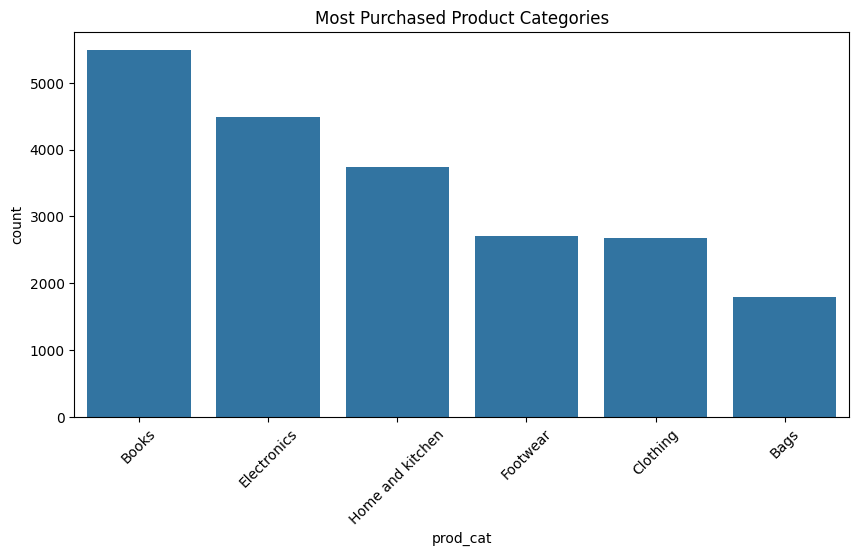

In [ ]:
# Task 3: Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 5))
sns.countplot(data=merged_df, x='prod_cat', order=merged_df['prod_cat'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Most Purchased Product Categories")
plt.show()

In [ ]:
# Task 4: Recommendation Techniques

# Content-Based Filtering
vectorizer = TfidfVectorizer(stop_words='english')
prod_features = vectorizer.fit_transform(merged_df['prod_cat'] + " " + merged_df['prod_subcat'])
similarity_matrix = cosine_similarity(prod_features)
# Function to recommend products based on content similarity
def recommend_products(product_name, num_recommendations=5):
    product_indices = merged_df[merged_df['prod_cat'] == product_name].index
    if len(product_indices) == 0:
        return "No recommendations available"
    product_idx = product_indices[0]
    similar_indices = np.argsort(similarity_matrix[product_idx])[-(num_recommendations+1):-1][::-1]
    return merged_df.iloc[similar_indices][['prod_cat', 'prod_subcat']]

# Collaborative Filtering
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(merged_df[['cust_id', 'prod_cat_code', 'Qty']], reader)

# Split the data using Surprise's train_test_split function
from surprise.model_selection import train_test_split
# Use train_test_split directly, not surprise_train_test_split
trainset, testset = train_test_split(data, test_size=0.2)

# Fit the SVD model
model = SVD()
model.fit(trainset)
predictions = model.test(testset)


In [ ]:
# Task 5: Hybrid Model - Combining Content-Based & Collaborative Filtering
def hybrid_recommendations(user_id, product_name, num_recommendations=5):
    # Collaborative filtering recommendations (product IDs)
    collab_recommendations = [pred.iid for pred in model.test([(user_id, i, 4) for i in range(1, 10)])]

    # Content-based recommendations (product categories)
    content_recommendations = recommend_products(product_name)

    # If content-based recommendations return a DataFrame, extract 'prod_cat'
    if isinstance(content_recommendations, pd.DataFrame):
        content_recommendations = content_recommendations['prod_cat'].values

    # Extract product names or categories for collab recommendations
    collab_product_names = merged_df[merged_df['prod_cat_code'].isin(collab_recommendations)]['prod_cat'].values

    # Combine both recommendations (remove duplicates)
    combined_recommendations = list(set(collab_product_names) | set(content_recommendations))

    # Limit the number of recommendations
    return combined_recommendations[:num_recommendations]

# Example Hybrid Recommendation with a limit
recommendations = hybrid_recommendations(1001, "Electronics", num_recommendations=5)
print(recommendations)


['Books', 'Footwear', 'Electronics', 'Clothing', 'Bags']


<ipython-input-39-4c1d01ffcdf2>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=recommendations, palette="viridis")


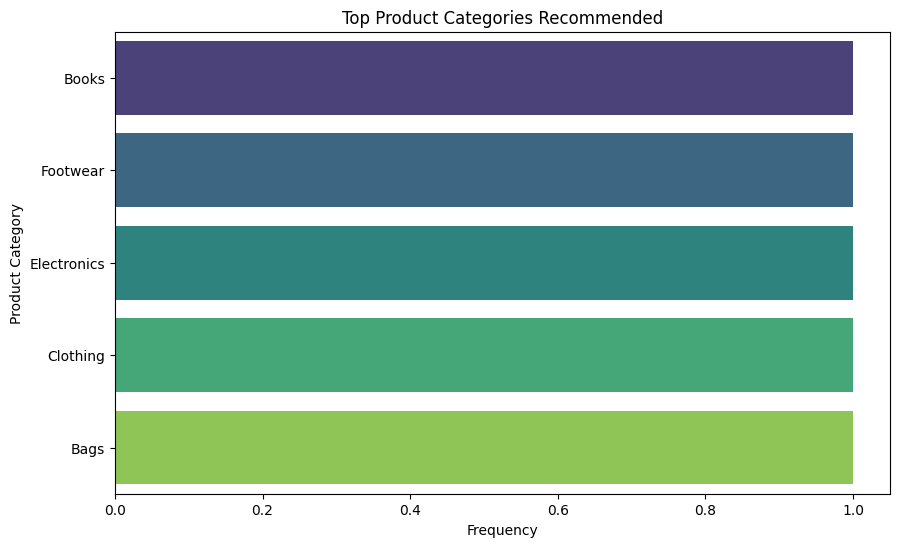

In [ ]:
import matplotlib.pyplot as plt

def visualize_recommendations(recommendations):
    # Create a bar chart of recommended product categories
    plt.figure(figsize=(10, 6))
    sns.countplot(y=recommendations, palette="viridis")
    plt.title("Top Product Categories Recommended")
    plt.xlabel("Frequency")
    plt.ylabel("Product Category")
    plt.show()

# Visualize the recommendations
visualize_recommendations(recommendations)

In [ ]:
# --------------------------- Task 6: Model Evaluation ---------------------------
def evaluate_model(predictions):
    # Calculate prediction accuracy
    y_true = [pred.r_ui for pred in predictions]
    y_pred = [pred.est for pred in predictions]
    accuracy = accuracy_score(np.round(y_true), np.round(y_pred))

    return accuracy

def success_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    return {"Precision": precision, "Recall": recall, "F1-Score": f1}


In [ ]:
# ---------------------------- Task 7: Cross-validation ---------------------------
def cross_validation(model_svd, data):
    # Performing cross-validation
    cross_validate(model_svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Generating evaluation metrics...
Metrics DataFrame:               Score
Precision  0.583333
Recall     0.583333
F1-Score   0.583333


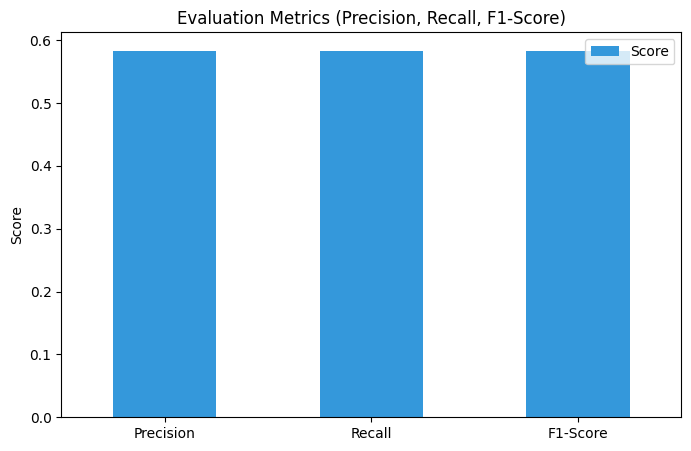

In [ ]:
def visualize_results(merged_df, model_svd, similarity_matrix):
    # Content-based vs Collaborative filtering recommendation comparison
    print("Generating Content-based recommendations...")
    rec_content = recommend_products("Electronics", merged_df, similarity_matrix, num_recommendations=5)['prod_cat'].values
    print(f"Content-based recommendations: {rec_content}")

    print("Generating Collaborative recommendations...")
    rec_collab = [str(item) for item in hybrid_recommendations(1001, "Electronics", merged_df, similarity_matrix, model_svd)]
    print(f"Collaborative recommendations: {rec_collab}")

    # Plot comparison of recommendations
    plt.figure(figsize=(10, 6))
    plt.hist([rec_content, rec_collab], label=["Content-Based", "Collaborative"], bins=10, alpha=0.7)
    plt.title("Recommendation Comparison: Content-Based vs Collaborative Filtering")
    plt.xlabel("Product Categories")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Performance metrics visualization should be outside the function
print("Generating evaluation metrics...")
metrics_df = pd.DataFrame.from_dict(success_metrics([1, 0, 1, 1, 0], [1, 1, 1, 0, 0]), orient='index', columns=['Score'])
print("Metrics DataFrame:", metrics_df)
metrics_df.plot(kind='bar', figsize=(8, 5), color=['#3498db', '#2ecc71', '#e74c3c'])
plt.title("Evaluation Metrics (Precision, Recall, F1-Score)")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Task 8: Evaluation Metrics
def evaluate_model(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)
    return {"Precision": precision, "Recall": recall, "F1-Score": f1}

cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5606  1.5492  1.5618  1.5747  1.5743  1.5641  0.0095  
MAE (testset)     1.3265  1.3161  1.3211  1.3327  1.3332  1.3259  0.0066  
Fit time          0.82    0.77    1.03    1.02    0.73    0.87    0.13    
Test time         0.10    0.04    0.14    0.03    0.34    0.13    0.11    


{'test_rmse': array([1.56059484, 1.54920113, 1.56178711, 1.57466557, 1.57427957]),
 'test_mae': array([1.32648586, 1.31606176, 1.32111402, 1.33265905, 1.33322769]),
 'fit_time': (0.822012186050415,
  0.770179271697998,
  1.034296989440918,
  1.0154173374176025,
  0.7251706123352051),
 'test_time': (0.09667849540710449,
  0.03527235984802246,
  0.14490556716918945,
  0.03387928009033203,
  0.3449575901031494)}

In [ ]:
def save_recommendations_to_csv(recommendations, filename="recommendations.csv"):
    # Save the recommendations list to a CSV file
    df = pd.DataFrame(recommendations, columns=["Recommended Categories"])
    df.to_csv(filename, index=False)
    print(f"Recommendations saved to {filename}")

# Save recommendations to CSV
save_recommendations_to_csv(recommendations)


Recommendations saved to recommendations.csv


In [ ]:
# prompt: how download recommendations.csv

from google.colab import files
files.download('recommendations.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>